In [101]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns

In [102]:
X = pd.read_csv('/mnt/ml-team/minerva/open-solutions/home-credit/files/unzipped_data/application_train.csv', 
                nrows=None)
X.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Preprocessing
## Solution 3

[Martin Kotek (Competition Host): "Value 365243 denotes infinity in DAYS variables in the datasets, therefore you can consider them NA values. Also XNA/XAP denote NA values."](https://www.kaggle.com/c/home-credit-default-risk/discussion/57247)

In [ ]:
X['CODE_GENDER'].unique()

In [ ]:
X.loc[X['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].unique()

In [ ]:
sum(X['ORGANIZATION_TYPE'] == 'XNA')

In [ ]:
X['CODE_GENDER'].value_counts()

In [ ]:
X['CODE_GENDER'].replace('XNA',np.nan, inplace=True)
X['CODE_GENDER'].value_counts()

# Feature Engineering
## Solution 3
### Hand crafted features

In [ ]:
X['annuity_income_percentage'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
X['car_to_birth_ratio'] = X['OWN_CAR_AGE'] / X['DAYS_BIRTH']
X['car_to_employ_ratio'] = X['OWN_CAR_AGE'] / X['DAYS_EMPLOYED']
X['children_ratio'] = X['CNT_CHILDREN'] / X['CNT_FAM_MEMBERS']
X['credit_to_annuity_ratio'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']
X['credit_to_goods_ratio'] = X['AMT_CREDIT'] / X['AMT_GOODS_PRICE']
X['credit_to_income_ratio'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']
X['days_employed_percentage'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
X['income_credit_percentage'] = X['AMT_INCOME_TOTAL'] / X['AMT_CREDIT']
X['income_per_child'] = X['AMT_INCOME_TOTAL'] / (1 + X['CNT_CHILDREN'])
X['income_per_person'] = X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']
X['payment_rate'] = X['AMT_ANNUITY'] / X['AMT_CREDIT']
X['phone_to_birth_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_BIRTH']
X['phone_to_employ_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_EMPLOYED']

In [ ]:
# External sources
X['external_sources_weighted'] = X.EXT_SOURCE_1 * 2 + X.EXT_SOURCE_2 * 3 + X.EXT_SOURCE_3 * 4
for function_name in ['min', 'max', 'sum', 'mean', 'nanmedian']:
    X['external_sources_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
        X[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [ ]:
engineered_numerical_columns = ['annuity_income_percentage',
                                'car_to_birth_ratio',
                                'car_to_employ_ratio',
                                'children_ratio',
                                'credit_to_annuity_ratio',
                                'credit_to_goods_ratio',
                                'credit_to_income_ratio',
                                'days_employed_percentage',
                                'income_credit_percentage',
                                'income_per_child',
                                'income_per_person',
                                'payment_rate',
                                'phone_to_birth_ratio',
                                'phone_to_employ_ratio',
                                'external_sources_weighted',
                                'external_sources_min',
                                'external_sources_max',
                                'external_sources_sum',
                                'external_sources_mean',
                                'external_sources_nanmedian']

In [ ]:
X_eng = X[engineered_numerical_columns + ['TARGET']]
X_eng_corr = abs(X_eng.corr())

In [ ]:
X_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

In [ ]:
sns.heatmap(X_eng_corr, 
            xticklabels=X_eng_corr.columns,
            yticklabels=X_eng_corr.columns)

### Aggregation features

In [ ]:
AGGREGATION_RECIPIES = [
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE'], [('AMT_ANNUITY', 'max'),
                                              ('AMT_CREDIT', 'max'),
                                              ('EXT_SOURCE_1', 'mean'),
                                              ('EXT_SOURCE_2', 'mean'),
                                              ('OWN_CAR_AGE', 'max'),
                                              ('OWN_CAR_AGE', 'sum')]),
    (['CODE_GENDER', 'ORGANIZATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                                            ('AMT_INCOME_TOTAL', 'mean'),
                                            ('DAYS_REGISTRATION', 'mean'),
                                            ('EXT_SOURCE_1', 'mean')]),
    (['CODE_GENDER', 'REG_CITY_NOT_WORK_CITY'], [('AMT_ANNUITY', 'mean'),
                                                 ('CNT_CHILDREN', 'mean'),
                                                 ('DAYS_ID_PUBLISH', 'mean')]),
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('EXT_SOURCE_1', 'mean'),
                                                                                           ('EXT_SOURCE_2', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE'], [('AMT_CREDIT', 'mean'),
                                                  ('AMT_REQ_CREDIT_BUREAU_YEAR', 'mean'),
                                                  ('APARTMENTS_AVG', 'mean'),
                                                  ('BASEMENTAREA_AVG', 'mean'),
                                                  ('EXT_SOURCE_1', 'mean'),
                                                  ('EXT_SOURCE_2', 'mean'),
                                                  ('EXT_SOURCE_3', 'mean'),
                                                  ('NONLIVINGAREA_AVG', 'mean'),
                                                  ('OWN_CAR_AGE', 'mean'),
                                                  ('YEARS_BUILD_AVG', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('ELEVATORS_AVG', 'mean'),
                                                                            ('EXT_SOURCE_1', 'mean')]),
    (['OCCUPATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                           ('CNT_CHILDREN', 'mean'),
                           ('CNT_FAM_MEMBERS', 'mean'),
                           ('DAYS_BIRTH', 'mean'),
                           ('DAYS_EMPLOYED', 'mean'),
                           ('DAYS_ID_PUBLISH', 'mean'),
                           ('DAYS_REGISTRATION', 'mean'),
                           ('EXT_SOURCE_1', 'mean'),
                           ('EXT_SOURCE_2', 'mean'),
                           ('EXT_SOURCE_3', 'mean')]),
]

In [ ]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    group_object = X.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        X = X.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

In [ ]:
X_agg = X[groupby_aggregate_names + ['TARGET']]
X_agg_corr = abs(X_agg.corr())

In [ ]:
X_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

In [ ]:
sns.heatmap(X_agg_corr, 
            xticklabels=X_agg_corr.columns,
            yticklabels=X_agg_corr.columns)

## Solution 4 
### Hand crafted features
* diff features

In [ ]:
diff_feature_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    for select, agg in tqdm(specs):
        if agg in ['mean','median','max','min']:
            groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
            diff_name = '{}_diff'.format(groupby_aggregate_name)
            abs_diff_name = '{}_abs_diff'.format(groupby_aggregate_name)

            X[diff_name] = X[select] - X[groupby_aggregate_name] 
            X[abs_diff_name] = np.abs(X[select] - X[groupby_aggregate_name]) 

            diff_feature_names.append(diff_name)
            diff_feature_names.append(abs_diff_name)

In [ ]:
X_diff = X[diff_feature_names + ['TARGET']]
X_diff_corr = abs(X_diff.corr())
X_diff_corr.sort_values('TARGET', ascending=False)['TARGET']

* unemployed

In [73]:
X['DAYS_EMPLOYED'].replace(365243,np.nan, inplace=True)

In [4]:
X_clean = X[~pd.isnull(X['DAYS_EMPLOYED'])]

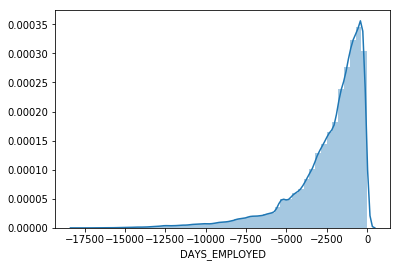

In [74]:
sns.distplot(X_clean['DAYS_EMPLOYED'])

In [75]:
X['DAYS_EMPLOYED'].describe()

count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

In [76]:
X['long_employment'] = (X['DAYS_EMPLOYED'] > -2000).astype(int)
feature_names = ['long_employment']

In [77]:
X_employment = X[feature_names +['DAYS_EMPLOYED'] + ['TARGET']]
X_employment_corr = abs(X_employment.corr())
X_employment_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET             1.000000
long_employment    0.082389
DAYS_EMPLOYED      0.074958
Name: TARGET, dtype: float64

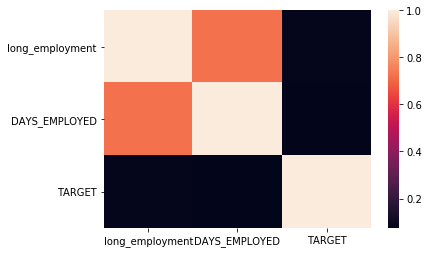

In [79]:
sns.heatmap(X_employment_corr, 
            xticklabels=X_employment_corr.columns,
            yticklabels=X_employment_corr.columns)

* age binns

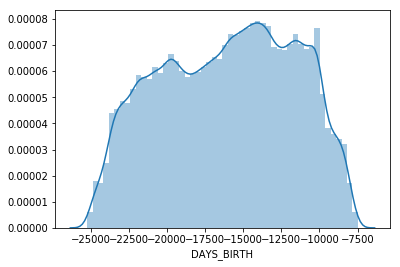

In [24]:
sns.distplot(X['DAYS_BIRTH'])

In [115]:
X['retirement_age'] = (X['DAYS_BIRTH'] > -14000).astype(int)
feature_names = ['DAYS_BIRTH_qcut','retirement_age']

In [117]:
X_age = X[feature_names +['DAYS_BIRTH'] + ['TARGET']]
X_age_corr = abs(X_age.corr())
X_age_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET            1.000000
DAYS_BIRTH        0.078239
retirement_age    0.067583
Name: TARGET, dtype: float64

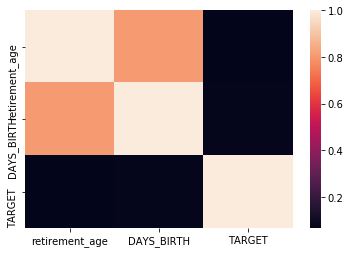

In [118]:
sns.heatmap(X_age_corr, 
            xticklabels=X_age_corr.columns,
            yticklabels=X_age_corr.columns)